In [36]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [44]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [45]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [46]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18.5
l_inner=10
c = np.array([30, 30])

qBase = np.array([c+l_inner*np.array([-(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([-(np.sqrt(3)/2), -1/2]), 
                  c+l_inner*np.array([(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([(np.sqrt(3)/2), -1/2]),
                  [30, 30+l_inner], [30, 30+l_inner+l]])


sub_regions = [[28, 4, 30, 5],
               [55, 35, 30, 5],
               [45, 15, 60, 35]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 60
x_min = 0
y_max = 60
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)

In [47]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [48]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 500 samples from Channel 3
Completed PredictedChannel 3
Drawing 500 samples from Channel 4
Completed PredictedChannel 4
Drawing 750 samples from Channel 5
Completed PredictedChannel 5
Drawing 750 samples from Channel 6
Completed PredictedChannel 6
[0.8288461538461539, 0.8349401110137307, 0.6644640234948604]


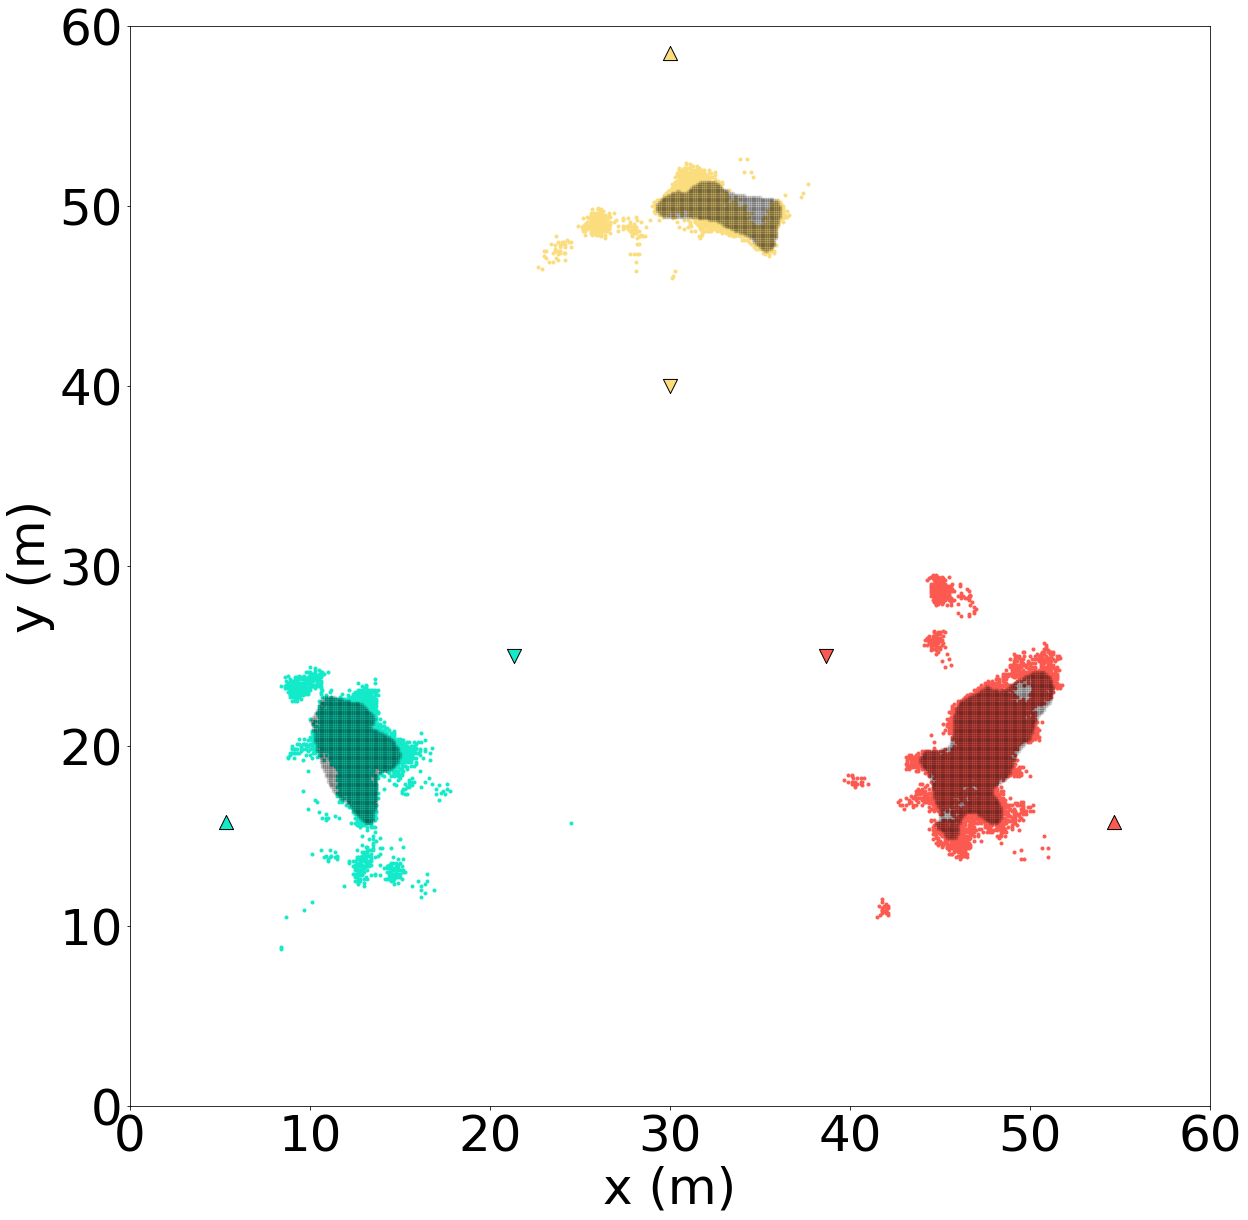

In [49]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [50]:
els = np.array([0.05, 0.05, 0.05])/beta
dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
14 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
6 total subregions


{'WT': 63.934286267913365, 'X': array([[15. , 19.6],
       [46.1, 22.4],
       [35.3, 47.5]]), 'pi': array([0.2854981 , 0.38331264, 0.33118926])}


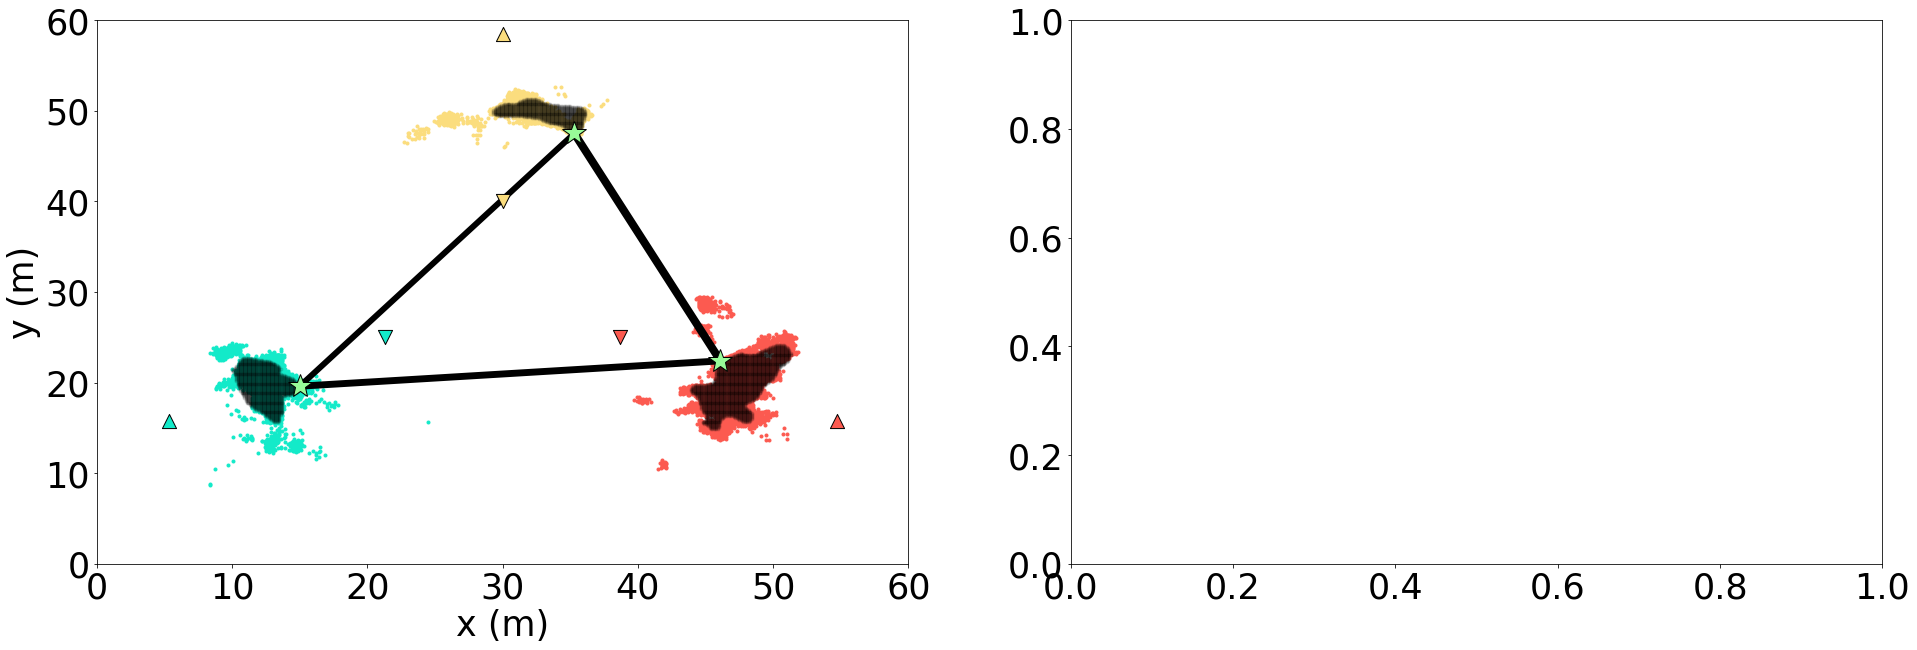

In [65]:
reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)

v = 1

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

figA, axsA = plt.subplots(1,2, figsize=(20, 10))
#######################
#Just a baseline plot
#######################
AORP = sim.calc_AORP(dt_sys, v)
print(AORP)
ax = axsA[0]
sim.plot_relay_regions(n, tjcps, pjcps, els = None, pi = None, ax = ax)
sim.plot_bs(qBase, ax)
sim.set_lims(region, ax)
sim.plot_AORP_routes(AORP, ax)
ax.invert_yaxis()
ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')
P_tilde, pi_tilde = sim.pi_to_P(pi)


Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 500 samples from Channel 3
Completed PredictedChannel 3
Drawing 500 samples from Channel 4
Completed PredictedChannel 4
Drawing 750 samples from Channel 5
Completed PredictedChannel 5
Drawing 750 samples from Channel 6
Completed PredictedChannel 6


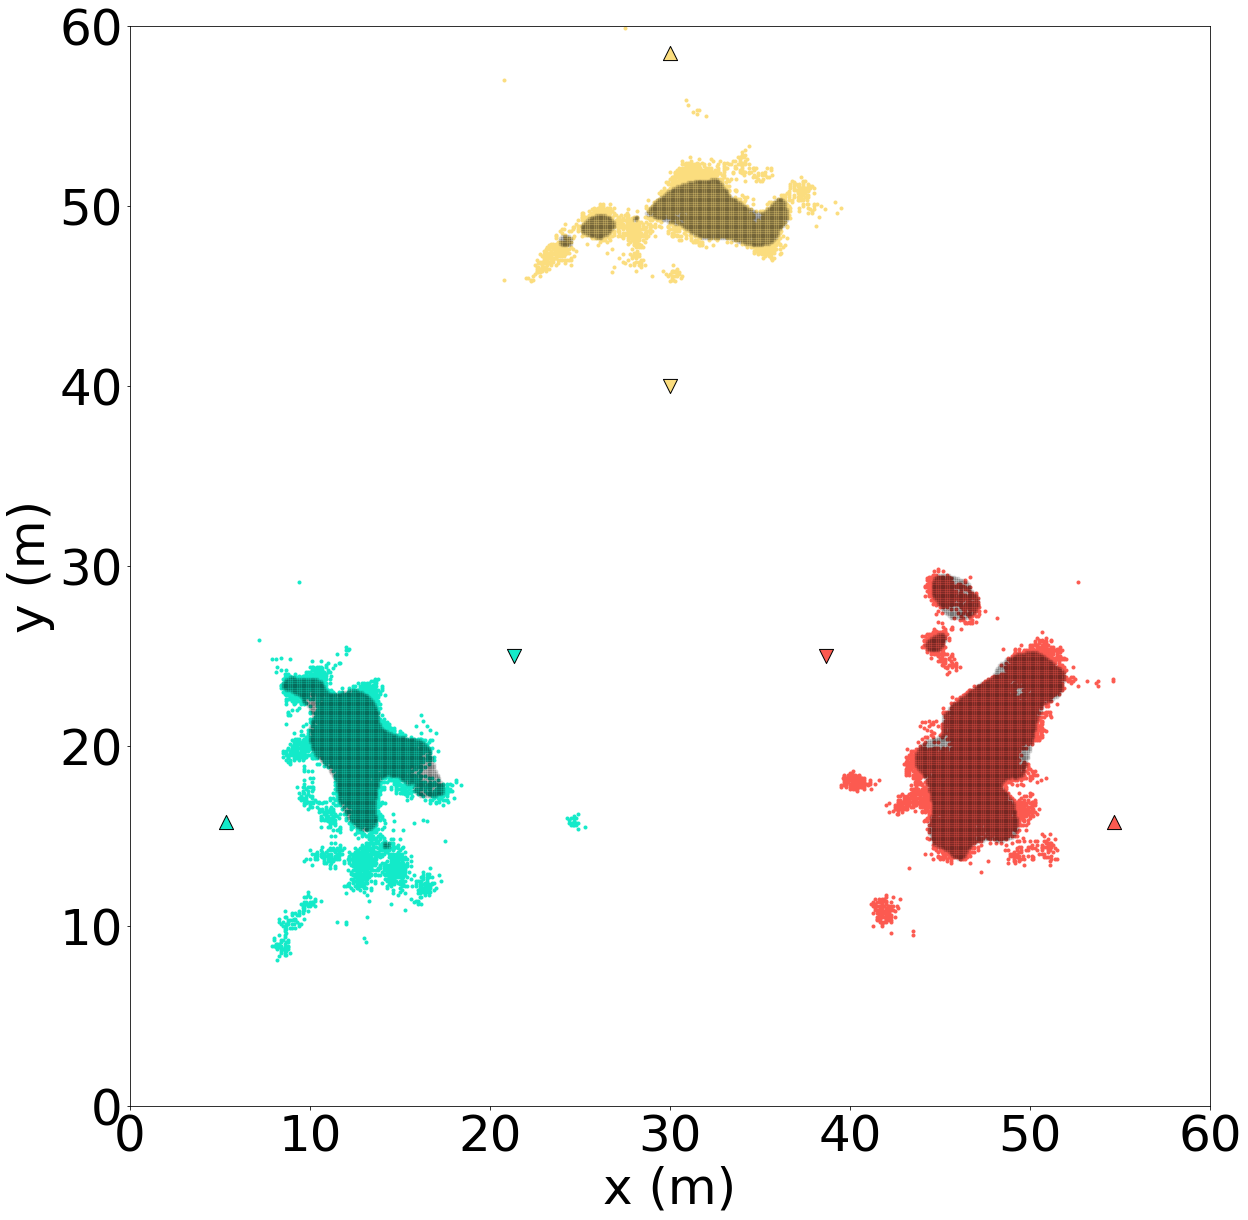

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
17 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
23 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
12 total subregions
{'WT': 57.156863504043244, 'X': array([[16.69999976, 19.70000025],
       [44.60000003, 29.09999997],
       [34.79021096, 47.82113457]]), 'pi': array([0.24178033, 0.41946918, 0.33875049])}


In [66]:
reload(sim)
#######################
#Now increase PL base line
#######################
kPL2 = -18
cps2 = [CC.ChannelParams(qBase[i], nPL, kPL2, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

ccs2 = [CC.CommChannel(cps2[i], sub_regions[(i)//2], res) for i in range(len(cps2))]
#use same MP and SH
for i in range(len(ccs2)):
    ccs2[i].gammaSHdB = ccs[i].gammaSHdB
    ccs2[i].gammaMPdB = ccs[i].gammaMPdB
cfs2, true_joint_con_fields2, tjcps2 = sim.find_true_conn(ccs2, GAMMA_TH)
pcs2, pfs2, pjcps2, prob_pred_con2 = sim.predict_channels(res, ccs2, true_joint_con_fields2, GAMMA_TH, p_th=p_th)

sim.plotCFwithOverlay(n, tjcps2, pjcps2, qBase, region)
plt.gca().invert_yaxis()
plt.show()

dt_sys2 = dtr.DTR(pcs2, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps2 = dt_sys2.ps

AORP = sim.calc_AORP(dt_sys2, v)
print(AORP)
pi=AORP['pi']
ax = axsA[1]
sim.plot_relay_regions(n, tjcps2, pjcps2, els = None, pi = None, ax = ax)
sim.plot_bs(qBase, ax)
sim.set_lims(region, ax)
sim.plot_AORP_routes(AORP, ax)
ax.invert_yaxis()
ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')
P_tilde, pi_tilde = sim.pi_to_P(pi)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


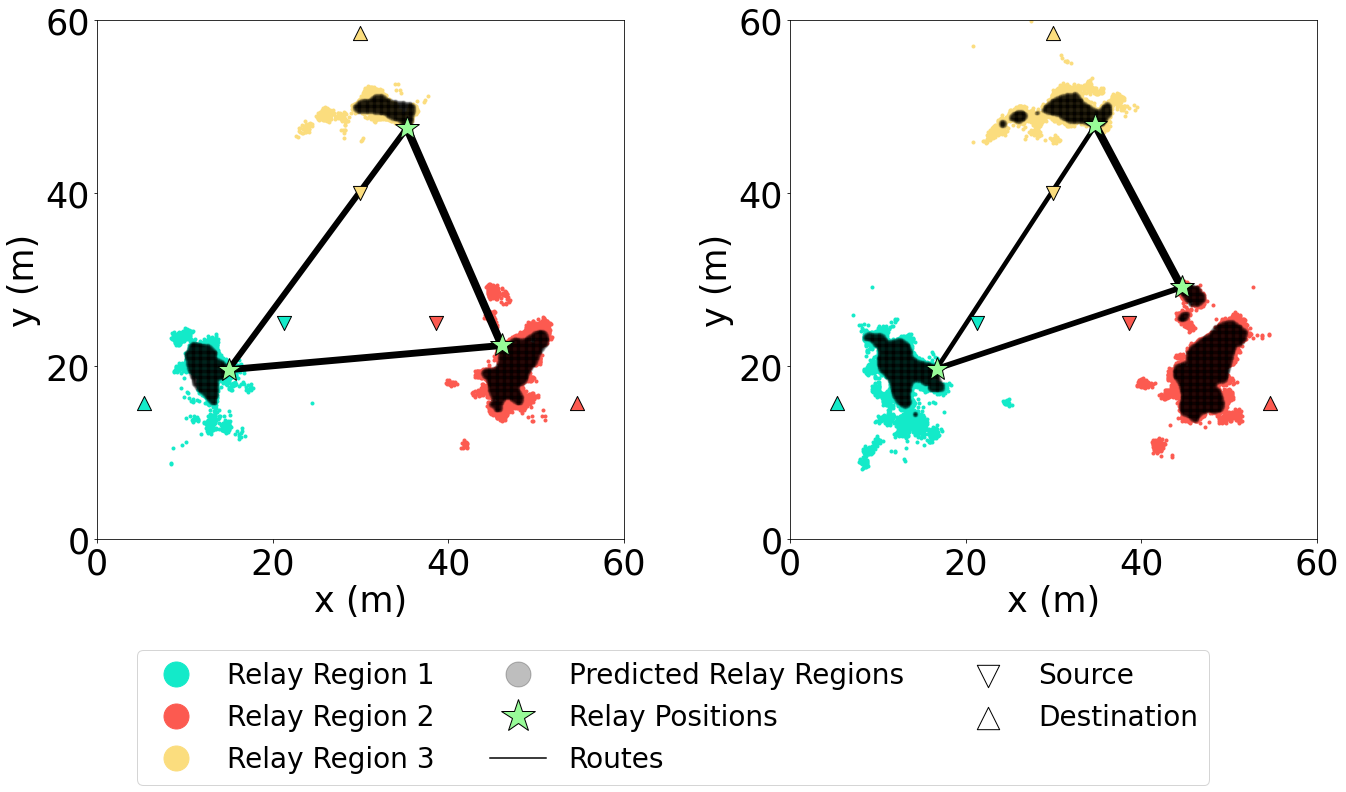

In [69]:
#legend.remove()
handles, labels = axsA[1].get_legend_handles_labels()
legend = figA.legend(handles, labels, loc='upper center', bbox_to_anchor=[0.5,0.05], ncol=3, prop={"size":28})
figA.tight_layout()
figA

In [70]:
figA.savefig("FIG_KPL_variance.png", format='png', bbox_inches='tight')
figA.savefig("FIG_KPL_variance.eps", format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 500 samples from Channel 3
Completed PredictedChannel 3
Drawing 500 samples from Channel 4
Completed PredictedChannel 4
Drawing 750 samples from Channel 5
Completed PredictedChannel 5
Drawing 750 samples from Channel 6
Completed PredictedChannel 6


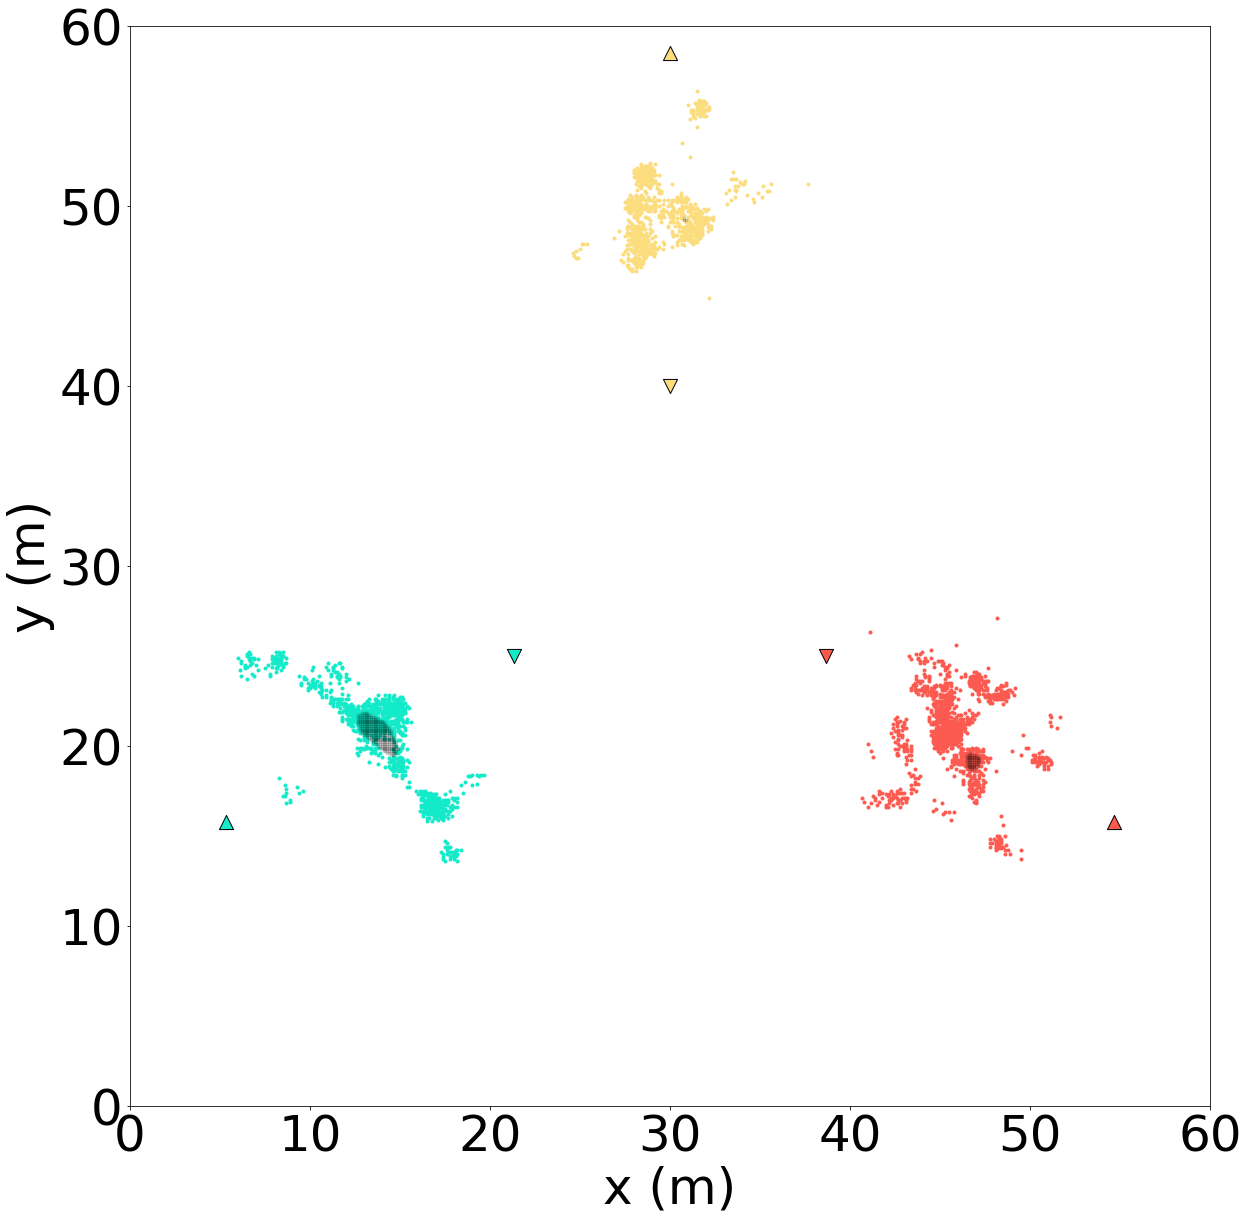

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
2 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
1 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([30.9 49.2])  ([30.8 49.3])  ([30.8 49.2]) Is Interior: False
1 total subregions
{'WT': 67.81343139581068, 'X': array([[14.39999999, 21.00000001],
       [46.50000001, 19.49999999],
       [30.80000023, 49.2       ]]), 'pi': array([0.34389389, 0.33107962, 0.32502649])}


In [54]:
#######################
#Now increase shaddowing coefficient - not interesting
#######################
sigmaMP3 = 3
cps3 = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP3) for i in range(len(qBase))]

ccs3 = [CC.CommChannel(cps3[i], sub_regions[(i)//2], res) for i in range(len(cps3))]
#use same MP
for i in range(len(ccs3)):
    ccs3[i].generateSH()
    ccs3[i].gammaMPdB = ccs[i].gammaMPdB
cfs3, true_joint_con_fields3, tjcps3 = sim.find_true_conn(ccs3, GAMMA_TH)
pcs3, pfs3, pjcps3, prob_pred_con3 = sim.predict_channels(res, ccs3, true_joint_con_fields3, GAMMA_TH, p_th=p_th)

sim.plotCFwithOverlay(n, tjcps3, pjcps3, qBase, region)
plt.gca().invert_yaxis()
plt.show()

dt_sys3 = dtr.DTR(pcs3, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps3 = dt_sys3.ps

AORP = sim.calc_AORP(dt_sys3, v)
print(AORP)
fig = plt.figure(figsize=(12,12))
ax = plt.gca()
sim.plot_relay_regions(n, tjcps3, pjcps3, els = None, pi = None, ax = ax)
sim.plot_bs(qBase, ax)
sim.set_lims(region, ax)
sim.plot_AORP_routes(AORP, ax)
ax.invert_yaxis()
ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')
P_tilde, pi_tilde = sim.pi_to_P(pi)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 500 samples from Channel 3
Completed PredictedChannel 3
Drawing 500 samples from Channel 4
Completed PredictedChannel 4
Drawing 750 samples from Channel 5
Completed PredictedChannel 5
Drawing 750 samples from Channel 6
Completed PredictedChannel 6


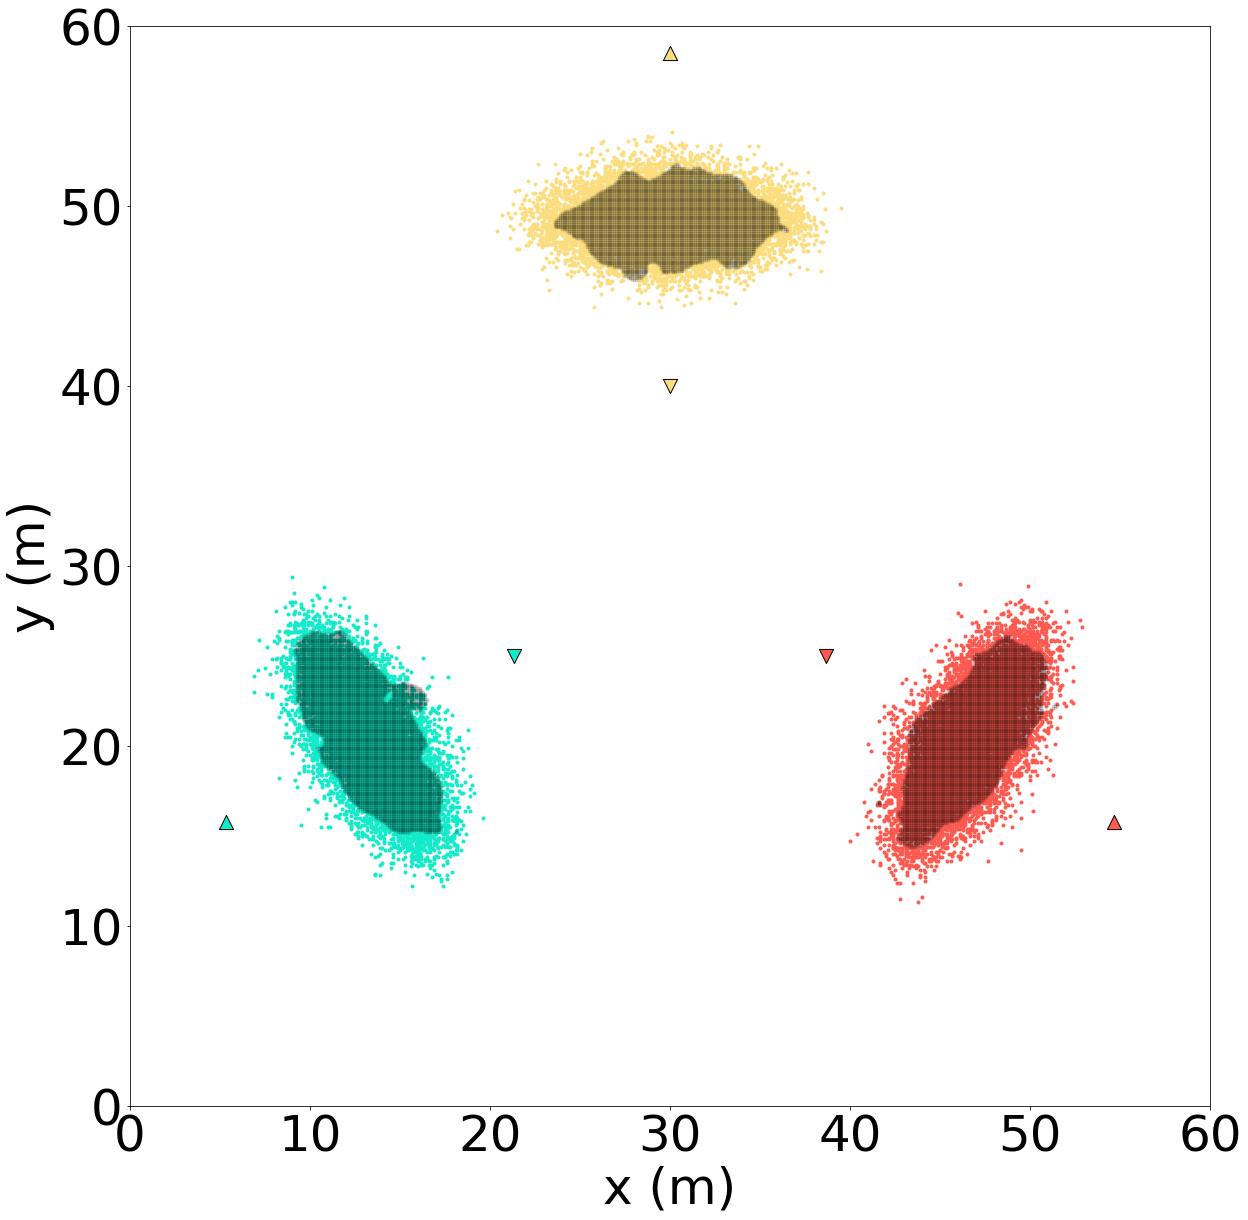

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
15 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
17 total subregions
{'WT': 56.508832821318215, 'X': array([[16.4, 22.9],
       [43.3, 20.9],
       [28.1, 45.9]]), 'pi': array([0.36407055, 0.30976113, 0.32616832])}


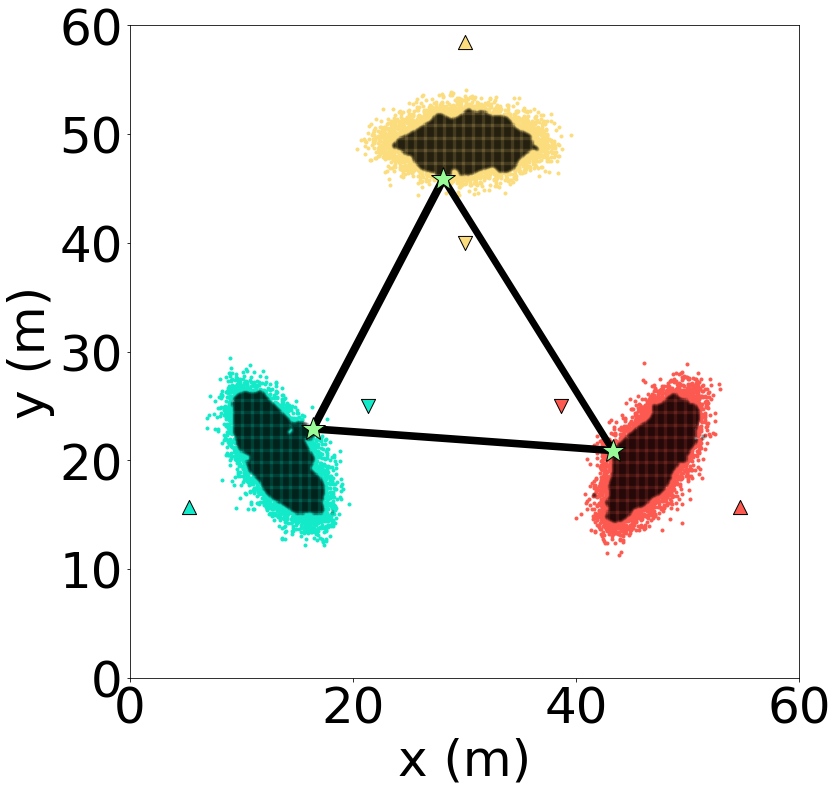

In [56]:
#######################
#Now increase PL coefficient
#######################
nPL4 = 4.8
cps4 = [CC.ChannelParams(qBase[i], nPL4, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

ccs4 = [CC.CommChannel(cps4[i], sub_regions[(i)//2], res) for i in range(len(cps4))]
#use same MP
for i in range(len(ccs4)):
    ccs2[i].gammaSHdB = ccs[i].gammaSHdB
    ccs4[i].gammaMPdB = ccs[i].gammaMPdB
cfs4, true_joint_con_fields4, tjcps4 = sim.find_true_conn(ccs4, GAMMA_TH)
pcs4, pfs4, pjcps4, prob_pred_con4 = sim.predict_channels(res, ccs4, true_joint_con_fields4, GAMMA_TH, p_th=p_th)

sim.plotCFwithOverlay(n, tjcps4, pjcps4, qBase, region)
plt.gca().invert_yaxis()
plt.show()

dt_sys4 = dtr.DTR(pcs4, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps4 = dt_sys4.ps

AORP = sim.calc_AORP(dt_sys4, v)
print(AORP)
fig = plt.figure(figsize=(12,12))
ax = plt.gca()
sim.plot_relay_regions(n, tjcps4, pjcps4, els = None, pi = None, ax = ax)
sim.plot_bs(qBase, ax)
sim.set_lims(region, ax)
sim.plot_AORP_routes(AORP, ax)
ax.invert_yaxis()
ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')
P_tilde, pi_tilde = sim.pi_to_P(pi)